In [ ]:
!pip3 install matplotlib scipy

Just picture

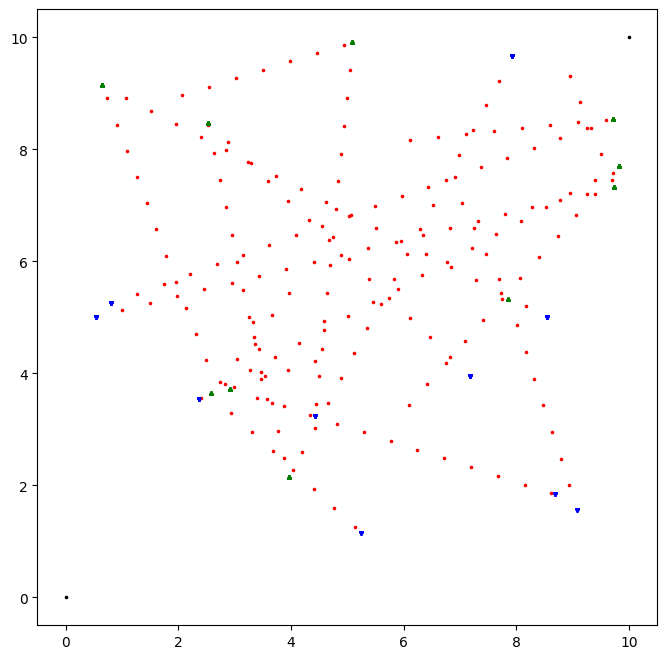

In [171]:

acroutes = [ActiveRoute(c, o) for c, o in zip(couriers, orders)]

fig, ax = plt.subplots()
frame = (Point(0, 0), Point(10, 10))
frame[0].plot(ax, color='black')
frame[1].plot(ax, color='black')
fig.set_figheight(8)
fig.set_figwidth(8)

for iter in range(100):
    for ar in acroutes:
        if ar.is_active:
            ar.plot(ax)
            ar.next(0.5)

Base launch

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import utils
import dispatch
import simulator
import dispatch.network
import importlib
importlib.reload(utils)
importlib.reload(dispatch.dispatch)
importlib.reload(dispatch.scorings)
importlib.reload(simulator.base_simulator)
importlib.reload(simulator.visualization)

from utils import *
from dispatch.dispatch import Dispatch
from simulator.base_simulator import BaseSimulator
from simulator.visualization import Visualizer

c:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\Danill\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


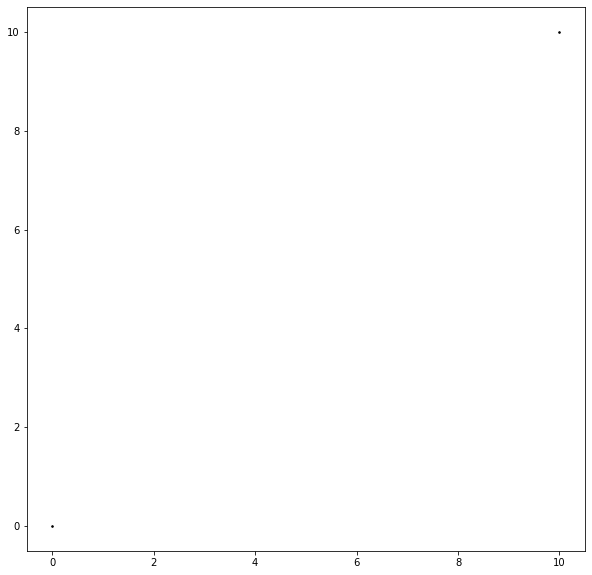

In [61]:
dsp = Dispatch()
sim = BaseSimulator(dsp, 0.5)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
    
sim.corner_bounds[0].plot(ax, color='black')
sim.corner_bounds[1].plot(ax, color='black')

all_metrics = []
for i in range(2000):
    metrics = sim.GetMetrics()
    all_metrics.append(metrics)
    sim.Next()
    # for ar in sim.active_routes:
    #     ar.plot(ax)

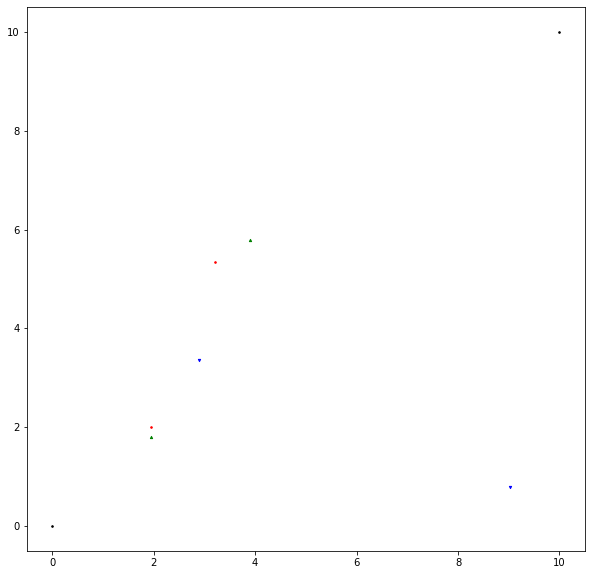

In [55]:
# hand launch visualization
sim.Next()
for ar in sim.active_routes:
    ar.plot(ax)
fig

mrtrics

CR:  0.9880216536408191


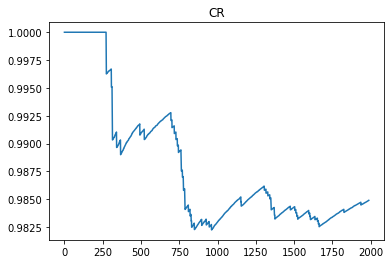

current free couriers:  31.109
current free orders:  0.905
current active routes:  28.891


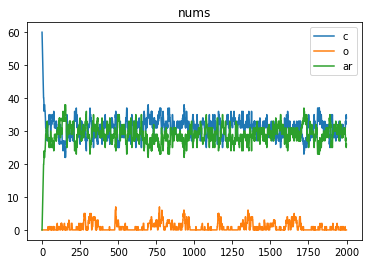

In [63]:
plt.title('CR')
plt.plot([m['completed_orders'] / m['finished_orders'] for m in all_metrics if m['finished_orders'] != 0])
print('CR: ', np.mean([m['completed_orders'] / m['finished_orders'] for m in all_metrics if m['finished_orders'] != 0]))
plt.show()
plt.title('nums')
plt.plot([m['current_free_couriers'] for m in all_metrics], label='c')
plt.plot([m['current_free_orders'] for m in all_metrics], label='o')
plt.plot([m['current_active_routes'] for m in all_metrics], label='ar')
plt.legend()
print('current free couriers: ', np.mean([m['current_free_couriers'] for m in all_metrics]))
print('current free orders: ', np.mean([m['current_free_orders'] for m in all_metrics]))
print('current active routes: ', np.mean([m['current_active_routes'] for m in all_metrics]))

In [64]:
sim.GetMetrics()

{'iter': 2000,
 'completed_orders': 3913,
 'finished_orders': 3973,
 'current_free_couriers': 34,
 'current_free_orders': 1,
 'current_active_routes': 26,
 'total_eta': 0.20270903438005933}

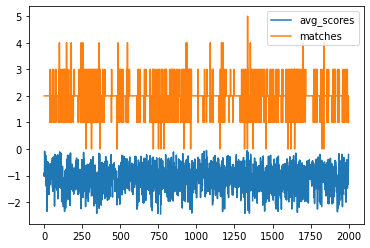

In [65]:
plt.plot(sim.dispatch.statistics['avg_scores'], label='avg_scores')
plt.plot(sim.dispatch.statistics['num_assignments'], label='matches')
plt.legend()

Net launch

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import utils
import dispatch
import simulator
import dispatch.network
import importlib
importlib.reload(utils)
importlib.reload(dispatch.dispatch)
importlib.reload(dispatch.scorings)
importlib.reload(simulator.base_simulator)
importlib.reload(simulator.visualization)
importlib.reload(dispatch.network)

from utils import *
from dispatch.utils import *
from dispatch.network import ScoringNet
from dispatch.scorings import ETAScoring
from dispatch.dispatch import Dispatch
from simulator.base_simulator import BaseSimulator
from simulator.visualization import Visualizer
from IPython.display import clear_output

In [15]:
def make_target_tensor(np_scores, mask):
    with torch.no_grad():
        target = mask.float()
        for idx, scores in enumerate(np_scores):
            source = torch.tensor(scores)
            target[idx][:source.shape[-2], :source.shape[-1]] = source
            
        return target

def get_loss(net, scorer, triples):
    np_scores = [scorer(triple.orders, triple.couriers) for triple in triples]
    preds = net(triples, 0)
    mask = net.get_mask()
    tgt = make_target_tensor(np_scores, mask)

    mse_loss = nn.MSELoss(reduction='none')
    return (mse_loss(preds, tgt) * mask).sum() / mask.sum()

[5520.51611328125, 113.10330200195312, 913.5908813476562, 857.89208984375, 190.05810546875, 71.70142364501953, 68.80754852294922, 143.197509765625, 44.323490142822266, 82.46602630615234]


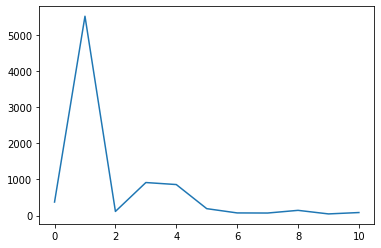

In [16]:
batch_size = 256
n_epochs = 100 + 1
bounds = (Point(0, 0), Point(10, 10))

net = ScoringNet(
    n_layers=4,
    d_model=512,
    n_head=8,
    dim_ff=512,
    pos_enc_dim=128,
    device=torch.device('cuda:0')
)
scorer = ETAScoring()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs=n_epochs, steps_per_epoch=1)

losses = []

In [ ]:
for epoch in range(n_epochs):
    triples = [random_triple(bounds) for _ in range(batch_size)]

    optimizer.zero_grad()
    loss = get_loss(net, scorer, triples)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if epoch % 1 == 0:
        clear_output()
        print(losses)
        plt.plot(np.log(losses))
        plt.show()

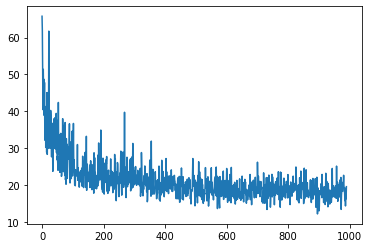

In [148]:
plt.plot(losses[10:])

Some tests

In [42]:
oe = OrderEncoder()
o = random_order(bounds)
oe(o, 0).shape

torch.Size([256])